In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


In [18]:
# Load dataset
df = pd.read_csv("volkswagen_e_golf.csv")

# Define features and target
features = ['power(kW)', 'quantity(kWh)', 'tire_type', 'city', 'motor_way',
            'country_roads', 'driving_style', 'consumption(kWh/100km)',
            'A/C', 'park_heating', 'avg_speed(km/h)', 'ecr_deviation', 'efficiency_km_per_kWh']
target = 'trip_distance(km)'
df.head()

,manufacturer,model,version,power(kW),fuel_date,trip_distance(km),quantity(kWh),fuel_type,tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
0,Volkswagen,Golf,e-Golf,85,08.02.2019,80,NaN,Electricity,Winter tires,0,0,1,Normal,17.8,0,1,53.0,1.0
1,Volkswagen,Golf,e-Golf,85,06.02.2019,50,12.29,Electricity,Winter tires,0,0,1,Normal,15.5,0,1,47.0,-1.3
2,Volkswagen,Golf,e-Golf,85,05.02.2019,43,8.68,Electricity,Winter tires,0,1,1,Normal,18.0,0,1,58.0,1.2
3,Volkswagen,Golf,e-Golf,85,04.02.2019,44,1.50,Electricity,Winter tires,0,1,1,Normal,16.1,0,1,43.0,-0.7
4,Volkswagen,Golf,e-Golf,85,04.02.2019,76,14.44,Electricity,Winter tires,0,1,0,Normal,19.0,0,1,76.0,2.2


In [19]:
# Convert categorical variables
df['tire_type'] = df['tire_type'].map({'Winter tires': 1, 'Summer tires': 0})
df['driving_style'] = df['driving_style'].astype('category').cat.codes

# Ensure trip_distance and quantity(kWh) are numeric
df['trip_distance(km)'] = pd.to_numeric(df['trip_distance(km)'], errors='coerce')
df['quantity(kWh)'] = pd.to_numeric(df['quantity(kWh)'], errors='coerce')

In [20]:
df.head()

,manufacturer,model,version,power(kW),fuel_date,trip_distance(km),quantity(kWh),fuel_type,tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
0,Volkswagen,Golf,e-Golf,85,08.02.2019,80.0,NaN,Electricity,1,0,0,1,2,17.8,0,1,53.0,1.0
1,Volkswagen,Golf,e-Golf,85,06.02.2019,50.0,12.29,Electricity,1,0,0,1,2,15.5,0,1,47.0,-1.3
2,Volkswagen,Golf,e-Golf,85,05.02.2019,43.0,8.68,Electricity,1,0,1,1,2,18.0,0,1,58.0,1.2
3,Volkswagen,Golf,e-Golf,85,04.02.2019,44.0,1.50,Electricity,1,0,1,1,2,16.1,0,1,43.0,-0.7
4,Volkswagen,Golf,e-Golf,85,04.02.2019,76.0,14.44,Electricity,1,0,1,0,2,19.0,0,1,76.0,2.2


In [21]:
# Handle missing values after conversion
df = df.dropna(subset=['trip_distance(km)', 'quantity(kWh)'])

In [24]:
# Compute efficiency safely
df['efficiency_km_per_kWh'] = df['trip_distance(km)'] / df['quantity(kWh)']

In [25]:
# Drop missing values
df = df.dropna(subset=[target])

In [26]:
df

,manufacturer,model,version,power(kW),fuel_date,trip_distance(km),quantity(kWh),fuel_type,tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation,efficiency_km_per_kWh
1,Volkswagen,Golf,e-Golf,85,06.02.2019,50.0,12.29,Electricity,1,0,0,1,2,15.5,0,1,47.0,-1.3,4.068348
2,Volkswagen,Golf,e-Golf,85,05.02.2019,43.0,8.68,Electricity,1,0,1,1,2,18.0,0,1,58.0,1.2,4.953917
3,Volkswagen,Golf,e-Golf,85,04.02.2019,44.0,1.50,Electricity,1,0,1,1,2,16.1,0,1,43.0,-0.7,29.333333
4,Volkswagen,Golf,e-Golf,85,04.02.2019,76.0,14.44,Electricity,1,0,1,0,2,19.0,0,1,76.0,2.2,5.263158
5,Volkswagen,Golf,e-Golf,85,03.02.2019,15.0,6.84,Electricity,1,1,0,0,2,16.1,0,1,23.0,-0.7,2.192982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,Volkswagen,Golf,e-Golf,85,20.12.2014,26.0,5.62,Electricity,1,1,1,1,2,21.6,1,0,45.0,4.8,4.626335
3341,Volkswagen,Golf,e-Golf,85,20.12.2014,77.0,14.25,Electricity,1,1,1,1,2,18.5,1,0,42.0,1.7,5.403509
3342,Volkswagen,Golf,e-Golf,85,19.12.2014,26.0,4.97,Electricity,1,1,1,1,2,19.1,1,0,23.0,2.3,5.231388
3343,Volkswagen,Golf,e-Golf,85,19.12.2014,20.0,4.76,Electricity,1,1,1,1,0,23.8,1,0,46.0,7.0,4.201681


In [27]:
# ---------------------- Step 1: Load & Prepare Data ----------------------

# Normalize features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Convert to PyTorch tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df[target].values, dtype=torch.float32)

# Define sequence length
sequence_length = 5

# Function to create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.stack(X_seq), torch.tensor(y_seq)

# Generate sequences
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
# ---------------------- Step 2: Define LSTM Model ----------------------

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output single trip distance value

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Take last output step

# Initialize model
input_size = len(features)
model = LSTMModel(input_size)

# Define loss function & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [29]:
# ---------------------- Step 3: Train the Model ----------------------

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch).squeeze()
            val_loss += criterion(y_pred, y_batch).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/20, Train Loss: nan, Val Loss: nan
Epoch 2/20, Train Loss: nan, Val Loss: nan
Epoch 3/20, Train Loss: nan, Val Loss: nan
Epoch 4/20, Train Loss: nan, Val Loss: nan
Epoch 5/20, Train Loss: nan, Val Loss: nan
Epoch 6/20, Train Loss: nan, Val Loss: nan
Epoch 7/20, Train Loss: nan, Val Loss: nan
Epoch 8/20, Train Loss: nan, Val Loss: nan
Epoch 9/20, Train Loss: nan, Val Loss: nan
Epoch 10/20, Train Loss: nan, Val Loss: nan
Epoch 11/20, Train Loss: nan, Val Loss: nan
Epoch 12/20, Train Loss: nan, Val Loss: nan
Epoch 13/20, Train Loss: nan, Val Loss: nan
Epoch 14/20, Train Loss: nan, Val Loss: nan
Epoch 15/20, Train Loss: nan, Val Loss: nan
Epoch 16/20, Train Loss: nan, Val Loss: nan
Epoch 17/20, Train Loss: nan, Val Loss: nan
Epoch 18/20, Train Loss: nan, Val Loss: nan
Epoch 19/20, Train Loss: nan, Val Loss: nan
Epoch 20/20, Train Loss: nan, Val Loss: nan


In [16]:
# ---------------------- Step 4: Make Predictions ----------------------

model.eval()
with torch.no_grad():
    sample_input = X_val[:5]  # Take a few samples from validation set
    predicted_range = model(sample_input).squeeze()

print("\nPredicted Effective Range (km):", predicted_range.numpy())


Predicted Effective Range (km): [nan nan nan nan nan]


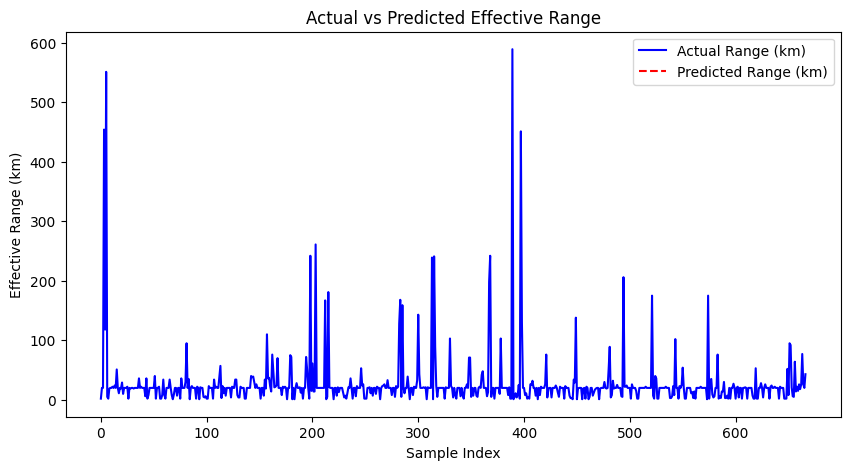

In [30]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Store actual and predicted values
actual_values = []
predicted_values = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch).squeeze()  # Get predictions

        actual_values.extend(y_batch.numpy())  # Store actual values
        predicted_values.extend(y_pred.numpy())  # Store predictions

# Convert to NumPy arrays for plotting
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

# 🔹 Plot Actual vs Predicted Values 🔹
plt.figure(figsize=(10, 5))
plt.plot(actual_values, label="Actual Range (km)", color='blue')
plt.plot(predicted_values, label="Predicted Range (km)", color='red', linestyle='dashed')
plt.xlabel("Sample Index")
plt.ylabel("Effective Range (km)")
plt.title("Actual vs Predicted Effective Range")
plt.legend()
plt.show()
